# Identifying Irrational Patterns in NFL Playcalling using Inverse Probability of Treatment Weighting


In [2]:
# http://archive.advancedfootballanalytics.com/2008/09/predictability-on-2nd-and-10.html
# https://measureofdoubt.com/2011/06/15/game-theory-and-football-how-irrationality-affects-play-calling/

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import math
from scipy.stats import chi2_contingency
import time

np.random.seed(11235)

In [116]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold, KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
 

# Plays processed in Process_NFL_Plays.ipynb

In [5]:
plays = pd.read_csv('data/processed_plays.csv', index_col=0)

/Users/jessegalef/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
plays.head()

,gameid,qtr,min,sec,off,def,down,togo,ydline,description,...,cumulative_season_pass_average,cumulative_rush_yards,cumulative_pass_yards,cumulative_mean_rush_yards,cumulative_mean_pass_yards,cumulative_incompletion_percent,hurrying,runOutClock,timeunder,timehalf
0,20020905_SF@NYG,1.0,NaN,0,SF,NYG,NaN,NaN,NaN,J.Cortez kicks 75 yards from SF 30 to NYG -5. ...,...,5.429012,0.0,0.0,0.000000,0.000000,0.367560,False,False,NaN,NaN
1,20020905_SF@NYG,1.0,60.0,0,NYG,SF,1.0,10.0,80.0,(15:00) T.Barber left end to NYG 24 for 4 yard...,...,5.404839,0.0,0.0,0.000000,0.000000,0.369159,False,False,14.0,29.0
2,20020905_SF@NYG,1.0,59.0,25,NYG,SF,2.0,6.0,76.0,(14:25) K.Collins pass incomplete to J.Shockey...,...,5.404839,4.0,0.0,3.888478,5.404839,0.369159,False,False,13.0,28.0
3,20020905_SF@NYG,1.0,59.0,20,NYG,SF,3.0,6.0,76.0,(14:20) PENALTY on NYG-J.Shockey False Start ...,...,2.702419,4.0,0.0,3.888478,1.351210,0.842290,False,False,13.0,28.0
4,20020905_SF@NYG,1.0,59.0,20,NYG,SF,3.0,11.0,81.0,(14:20) (Shotgun) K.Collins pass intended for ...,...,2.702419,4.0,0.0,3.888478,1.351210,0.842290,False,False,13.0,28.0


In [5]:
plays.columns

Index([u'gameid', u'qtr', u'min', u'sec', u'off', u'def', u'down', u'togo',
       u'ydline', u'description', u'offscore', u'defscore', u'season', u'lead',
       u'passAttempt', u'incomplete', u'intercepted', u'sack', u'penalty',
       u'rushAttempt', u'playtype', u'nextoff', u'nextdown', u'nexttogo',
       u'nextpenalty', u'nextrushAttempt', u'nextpassAttempt', u'nextplaytype',
       u'ydsnet', u'nextydsnet', u'prevIncomplete', u'prevYdline', u'prevoff',
       u'prevdown', u'prevYdsnet', u'prevtogo', u'prevrushAttempt',
       u'prevpassAttempt', u'prevplaytype', u'prevpenalty', u'switch',
       u'passYards', u'rushYards', u'prev_season_rush_percent',
       u'def_prev_season_rush_percent', u'prev_season_rush_ydsnet_average',
       u'prev_season_pass_ydsnet_average',
       u'def_prev_season_rush_ydsnet_average',
       u'def_prev_season_pass_ydsnet_average',
       u'prev_season_incompletion_percent',
       u'def_prev_season_incompletion_percent',
       u'prev_season_offense

In [6]:
plays['suitable'] = True
plays.ix[(plays.down.isnull()), 'suitable'] = False
plays.ix[(plays.off != plays.prevoff), 'suitable'] = False
plays.ix[(plays.rushAttempt != 1) & (plays.passAttempt!=1), 'suitable'] = False
plays.ix[(plays.prevrushAttempt != 1) & (plays.prevpassAttempt!=1), 'suitable'] = False
plays.ix[(plays.penalty == 1) | (plays.prevpenalty == 1), 'suitable'] = False

present = plays[plays.suitable == True].copy()


In [7]:
second=present[(present.down==2)&(present.prevtogo==10)]

In [28]:
# Following the findings of "A comparison of the ability of different propensity score models to 
# balance measured variables between treated and untreated subjects: a Monte Carlo study"
# by Peter C. Austin, Paul Grootendorst and Geoffrey M. Anderson
# I'm controling for the features which are predictive of the target variable, rather than 
# predictive of the treatment.
    
# http://onlinelibrary.wiley.com/wol1/doi/10.1002/sim.2580/abstract

potential_features = ['timehalf',
 'togo',
 'ydline',
 'lead',
 'hurrying',
 'runOutClock',
 'prev_season_rush_percent',
 'def_prev_season_rush_percent',
 'prev_season_rush_ydsnet_average',
 'prev_season_pass_ydsnet_average',
 'def_prev_season_rush_ydsnet_average',
 'def_prev_season_pass_ydsnet_average',
 'prev_season_incompletion_percent',
 'def_prev_season_incompletion_percent',              
 'prev_season_offense_pass_yard_adv',
 'prev_season_offense_rush_yard_adv',
 'pass_comparative_adv',
 'cumulative_rush_yards',
 'cumulative_pass_yards',
 'cumulative_mean_rush_yards',
 'cumulative_mean_pass_yards',
 'cumulative_incompletion_percent',
 'cumulative_season_incompletion_percent', 
 'cumulative_season_rush_yards',
 'cumulative_season_rush_average', 
 'cumulative_season_pass_yards',
 'cumulative_season_pass_average',]

treatment = 'prevrushAttempt'
target= 'rushAttempt'



In [29]:
def get_feature_importances(X, target, target_type = 'classification'):
    """
    Given a dataframe of features X and a list-like target, trains a basic GradientBoosting model
    classifier by default but regressor if target_type is changed
    Returns a pandas Series of the feature importances
    
    """
    if target_type == 'classification':
        confounder_selector = GradientBoostingClassifier(max_depth=7)
    else:
        confounder_selector = GradientBoostingRegressor(max_depth=7)
        
    confounder_selector.fit(X, target)
    importances = pd.Series(confounder_selector.feature_importances_)
    if type(X) == pd.DataFrame:
        importances.index = X.columns

    return importances


In [54]:
feature_importances = get_feature_importances(second[potential_features], second.rushAttempt).sort_values(ascending=False)
print feature_importances

features = feature_importances[feature_importances >= .025].index.values

togo                                      0.090361
lead                                      0.062691
ydline                                    0.056148
cumulative_mean_rush_yards                0.053272
cumulative_incompletion_percent           0.051908
cumulative_pass_yards                     0.051078
cumulative_rush_yards                     0.047050
cumulative_season_pass_average            0.046710
cumulative_mean_pass_yards                0.044728
timehalf                                  0.044518
cumulative_season_incompletion_percent    0.040490
cumulative_season_rush_yards              0.040372
cumulative_season_rush_average            0.038028
cumulative_season_pass_yards              0.035150
prev_season_rush_percent                  0.030230
hurrying                                  0.027710
prev_season_incompletion_percent          0.027149
prev_season_rush_ydsnet_average           0.026265
prev_season_pass_ydsnet_average           0.024108
prev_season_offense_pass_yard_a

In [55]:
features

array(['togo', 'lead', 'ydline', 'cumulative_mean_rush_yards',
       'cumulative_incompletion_percent', 'cumulative_pass_yards',
       'cumulative_rush_yards', 'cumulative_season_pass_average',
       'cumulative_mean_pass_yards', 'timehalf',
       'cumulative_season_incompletion_percent',
       'cumulative_season_rush_yards', 'cumulative_season_rush_average',
       'cumulative_season_pass_yards', 'prev_season_rush_percent',
       'hurrying', 'prev_season_incompletion_percent',
       'prev_season_rush_ydsnet_average'], dtype=object)

In [34]:
len(plays.gameid.unique())

2918

In [35]:
present.ydsnet.describe()

count    254521.000000
mean          5.295280
std           8.473545
min         -38.000000
25%           0.000000
50%           3.000000
75%           8.000000
max          99.000000
Name: ydsnet, dtype: float64

## The situation: The appearance of an unexpected increase of rushing percent at second down and 10 to go compared to 2nd and other yardages

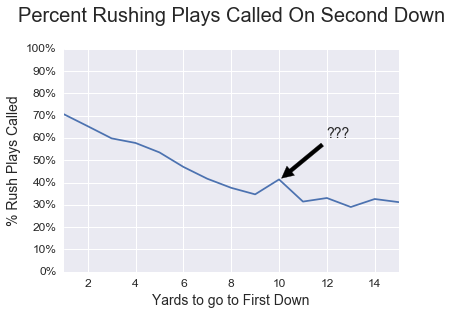

In [36]:

present[(present.togo<=15)&(present.down==2)&(present.prevtogo==10)].groupby(['togo']).mean()[['rushAttempt']].plot(legend=False)
plt.title('Percent Rushing Plays Called On Second Down\n', fontsize=20)
plt.xlabel('Yards to go to First Down', fontsize=14)
plt.ylabel('% Rush Plays Called', fontsize=14)
plt.ylim([0,.8])
plt.xticks(fontsize=12)
plt.yticks(np.arange(0,1.1,.1), [str(percent)+'%' for percent in range(0,110, 10)], fontsize=12)
plt.annotate('???', (10,.41), (12,.6), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)


# Hypotheses: 
1) Second and ten following incomplete passes are disproportionately the result of particular game situations - perhaps playing from behind or having a bad quarterback - which would impact the expected playcall balance anyway. Once controlled for, the imbalance might be explained away.

2) Coaches have a tendency to equate randomness with alternating. Since 2nd and 10 is disproportionately the result of a passing play, alternating would produce a disproportionate amount of rushing plays next.

3) Coaches have a recency bias, and weigh the result of the most recent play too heavily. If they see an incomplete pass as an indication that passing is a bad idea, they'll be likely to overreact and be too likely to switch to a rushing play next. 

http://archive.advancedfootballanalytics.com/2008/09/predictability.html

http://archive.advancedfootballanalytics.com/2008/09/predictability-on-2nd-and-10.html

https://measureofdoubt.com/2011/06/15/game-theory-and-football-how-irrationality-affects-play-calling/

# Approach:
* Use inverse propensity score weighting to control for (many) confounding factors, and see whether the difference between rushing rates after passes & rushes is still statistically significant. (Hypothesis 1)
* Once the samples are reweighted by inverse propensity score, compare the impact of previous playtype on the next playcall on 2nd and 10 to the impact of previous playcall on 2nd and 3.  If the alternation bias is the only effect, these should have reasonably similar differences. If not, there may be an impact of recency bias. (Hypotheses 2 & 3)

* Use bayesian inference to model the yards gained from rushes following passes and rushes. If being predictable is a liability, we would expect to see rushes to gain fewer yards in situaions where they are being called irrationally often.



In [37]:
df = second[second.togo==10]

# Example of confounding variable: incompletion so far in the game
## Which is positively correlated with 'follows a pass' and with 'rushes next'


## Note: I'm using gradient boosting classifier's feature importance to select which confounds to control for, rather than correlation because there may be complex non-linear relationships. These are still included and useful visualizations to illustrate the principle.

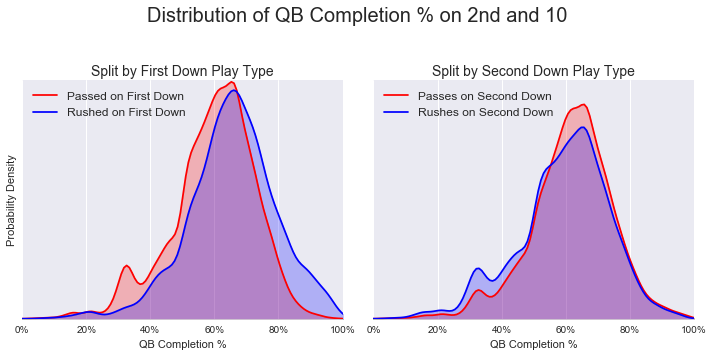

In [205]:
# I saved these as incompletion percent, which makes it awkward to make graphs about completion percent
# I feel silly.

plt.figure(figsize=[10,5])    
plt.suptitle('Distribution of QB Completion % on 2nd and 10', fontsize=20)
ax= plt.subplot(1,2,1)
plt.title('Split by First Down Play Type', fontsize=14)
sns.kdeplot(1-df[df.prevrushAttempt==0].cumulative_incompletion_percent, color='red', shade=True, label='Passed on First Down', clip=[0,1], ax=ax)
sns.kdeplot(1-df[df.prevrushAttempt==1].cumulative_incompletion_percent, color='blue', shade=True, label='Rushed on First Down', ax=ax, clip=[0,1])
plt.xlim([0,1])
plt.xlabel('QB Completion %')
plt.ylabel('Probability Density')
plt.yticks([])
plt.xticks([0,.2,.4,.6,.8,1], ['0%', '20%','40%','60%','80%','100%'])

plt.legend(fontsize=12, loc='upper left')

ax= plt.subplot(1,2,2)
plt.title('Split by Second Down Play Type', fontsize=14)
sns.kdeplot(1-df[df.rushAttempt==0].cumulative_incompletion_percent, color='red', shade=True, label='Passes on Second Down', clip=[0,1], ax=ax)
sns.kdeplot(1-df[df.rushAttempt==1].cumulative_incompletion_percent, color='blue', shade=True, label='Rushes on Second Down', ax=ax, clip=[0,1])
plt.xlim([0,1])
plt.xlabel('QB Completion %')
plt.yticks([])
plt.xticks([0,.2,.4,.6,.8,1], ['0%', '20%','40%','60%','80%','100%'])

plt.legend(fontsize=12, loc='upper left')
plt.tight_layout(rect=[0,0,1,.85])

# Second example of confound: Average Yards Per Pass on 2nd and 10
## Positively correlated with 'follows a rush' and 'passes next'

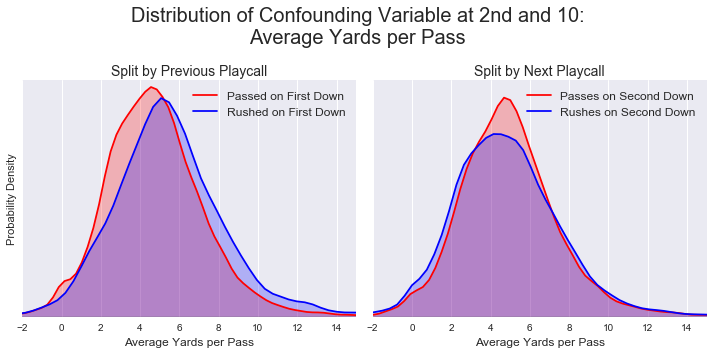

In [39]:
df = second[second.togo==10]
feature = 'cumulative_mean_pass_yards'
plt.figure(figsize=[10,5])    
plt.suptitle('Distribution of Confounding Variable at 2nd and 10:\nAverage Yards per Pass', fontsize=20)
ax= plt.subplot(1,2,1)
plt.title('Split by Previous Playcall', fontsize=14)
sns.kdeplot(df[df.prevrushAttempt==0][feature], color='red', shade=True, label='Passed on First Down', ax=ax, clip=[df[df.prevrushAttempt==0][feature].min(),df[df.prevrushAttempt==0][feature].max()])
sns.kdeplot(df[df.prevrushAttempt==1][feature], color='blue', shade=True, label='Rushed on First Down', ax=ax, clip=[df[df.prevrushAttempt==1][feature].min(),df[df.prevrushAttempt==1][feature].max()])
plt.xlim([-2,15])
plt.xlabel('Average Yards per Pass', fontsize=12)
plt.ylabel('Probability Density')
plt.yticks([])
plt.legend(fontsize=12)
ax= plt.subplot(1,2,2)
plt.title('Split by Next Playcall', fontsize=14)
sns.kdeplot(df[df.rushAttempt==0][feature], color='red', shade=True, label='Passes on Second Down', ax=ax, clip=[df[df.rushAttempt==0][feature].min(),df[df.rushAttempt==0][feature].max()])
sns.kdeplot(df[df.rushAttempt==1][feature], color='blue', shade=True, label='Rushes on Second Down', ax=ax, clip=[df[df.rushAttempt==0][feature].min(),df[df.rushAttempt==0][feature].max()])
plt.xlim([-2,15])
plt.xlabel('Average Yards per Pass', fontsize=12)
plt.yticks([])
plt.legend(fontsize=12)
plt.tight_layout(rect=[0,0,1,.85])

## Or a confound that would exacerbate the effect, lead - which is positively correlated with rushing previously and rushing next play.

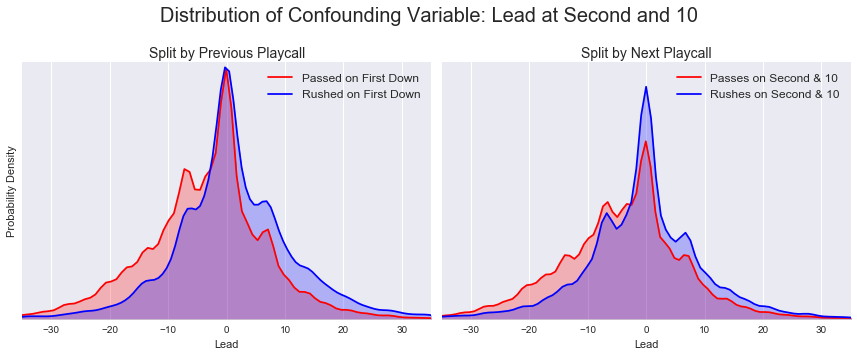

In [40]:

feature = 'lead'
plt.figure(figsize=[12,5])    
plt.suptitle('Distribution of Confounding Variable: Lead at Second and 10', fontsize=20)
ax= plt.subplot(1,2,1)
plt.title('Split by Previous Playcall', fontsize=14)
sns.kdeplot(df[df.prevrushAttempt==0][feature], color='red', shade=True, label='Passed on First Down', ax=ax, clip=[df[df.prevrushAttempt==0][feature].min(),df[df.prevrushAttempt==0][feature].max()])
sns.kdeplot(df[df.prevrushAttempt==1][feature], color='blue', shade=True, label='Rushed on First Down', ax=ax, clip=[df[df.prevrushAttempt==1][feature].min(),df[df.prevrushAttempt==1][feature].max()])
plt.xlim([-35,35])
plt.xlabel("Lead")
plt.ylabel('Probability Density')
plt.yticks([])
plt.legend(fontsize=12)
ax= plt.subplot(1,2,2)
plt.title('Split by Next Playcall', fontsize=14)
sns.kdeplot(df[df.rushAttempt==0][feature], color='red', shade=True, label='Passes on Second & 10', ax=ax, clip=[df[df.rushAttempt==0][feature].min(),df[df.rushAttempt==0][feature].max()])
sns.kdeplot(df[df.rushAttempt==1][feature], color='blue', shade=True, label='Rushes on Second & 10', ax=ax, clip=[df[df.rushAttempt==0][feature].min(),df[df.rushAttempt==0][feature].max()])
plt.xlim([-35,35])
plt.xlabel('Lead')
plt.yticks([])
plt.legend(fontsize=12)
plt.tight_layout(rect=[0,0,1,.9])

# Split the data by previous playcall type - Not yet controlling for confounds
## The spike in rushing at 2nd and 10 after a pass is still present

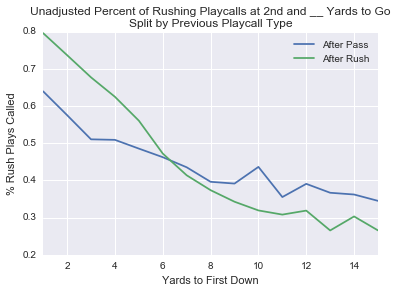

In [20]:
ax= present[(present.down==2)&(present.togo<=15)&(present.prevtogo==10)&(present.prevrushAttempt==0)].groupby('togo').mean()[['rushAttempt']].plot(label='After Pass')
present[(present.down==2)&(present.togo<=15)&(present.prevtogo==10)&(present.prevrushAttempt==1)].groupby('togo').mean()[['rushAttempt']].plot(label='After Rush', ax=ax)

ax.legend(['After Pass', 'After Rush'])

plt.title('Unadjusted Percent of Rushing Playcalls at 2nd and __ Yards to Go\nSplit by Previous Playcall Type')
plt.xlabel('Yards to First Down')
plt.ylabel('% Rush Plays Called')


# plt.xticks(range(0,16,2), range(1,16,2))
# plt.xticks(rotation=90)


In [41]:
# Verify that we fixed any nan entries
null_count = present[features].isnull().sum()
print null_count[null_count >0]
null_count_cols = present[features].isnull().sum()
print "null values in 'present' dataframe columns we're using in our model: ",null_count_cols.sum()


Series([], dtype: int64)
null values in 'present' dataframe columns we're using in our model:  0


In [42]:
def cv_predict_proba(estimator, X, y, n_folds=3, params={}, verbose=0):
    # Takes a estimator (classifier), X matrix, y (listlike), optional parameters for a gridsearch
    # If params are passed, uses a gridsearch on those parameters first and uses the best_estimator_
    
    # Uses a kfold to fit on successive random portions of the dataset and predict_proba on the remaining section
    # This avoids training the model with the data point we're trying to assign a propensity score
    
    # Returns a series of floats with the same index as y
    
    kfold = KFold(n=len(X),n_folds=n_folds, shuffle=True, random_state=42)
    probs = pd.Series(0, index=y.index)
    if params != {}:
        cv_kfold = KFold(n=len(X),n_folds=3, shuffle=True, random_state=42)
        grid = GridSearchCV(estimator, param_grid=params, scoring='roc_auc', cv=cv_kfold, verbose=verbose)
        if verbose>3: print 'gridsearching estimator hyperparameters'
        grid.fit(X,y)
        estimator = grid.best_estimator_

    for i, (train, test) in enumerate(kfold):
        if verbose >3: print 'getting probabilities for section', str(i)
        estimator.fit(X.iloc[train], y.iloc[train])
        probs.iloc[test] = estimator.predict_proba(X.iloc[test])[:,1]
    if verbose > 0:
        print "roc_auc score of", roc_auc_score(list(y), list(probs))
    return probs

In [43]:
params = {
        'max_depth': [3,5,8,15],
        'min_samples_split': [2,5,10],
        }

In [44]:
def get_df_weights(df, classifier=GradientBoostingClassifier(), X_columns=features, treatment='prevrushAttempt', n_folds=10, params={}, verbose=1):
    # Uses the passed classifier to create propensity scores and inverse-weights: 
    # Propensity score is the classifier's predicted probability that each observation in df is in 0 or 1 'treatment' group
    # based on the list of X_columns passed.
    
    # Weights are the inverse of the propensity score for the correct value - a datapoint given a score of .25
    # which was actually in treatment group 1 is given a preliminary weight of 4, while a datapoint 
    # given a score of .25 which was actually in treatment group 0 is given a preliminary weight of 1.33 (1 / .75)
    
    # Weights are normalized at the end so that the average weight is 1. 
    
    # If verbose is over 0, cv_predict_proba prints the roc_auc score at the end
    # If verbose is over 3, cv_predict_proba prints its progress through each fold
    
    p = cv_predict_proba(classifier, df[X_columns], df[treatment], n_folds=n_folds, params=params, verbose=verbose)
    weights = (df[treatment]/p)+(1.-df[treatment])/(1.-p)
    weights = (weights/weights.sum())*len(df)
    return p, weights

In [62]:
propensities, weights = get_df_weights(second[second.togo==10], 
                                       classifier=GradientBoostingClassifier(),
                                       X_columns=features,
                                       treatment='prevrushAttempt',
                                       n_folds=10,
                                       params=params,
                                       verbose=1)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.6min finished


roc_auc score of 0.789891106096


In [63]:
weights.describe()

count    25547.000000
mean         1.000000
std          1.275269
min          0.529228
25%          0.568179
50%          0.620919
75%          0.739029
max         35.501245
dtype: float64

In [65]:
df['weight'] = weights
df['propensity'] = propensities

/Users/jessegalef/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jessegalef/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


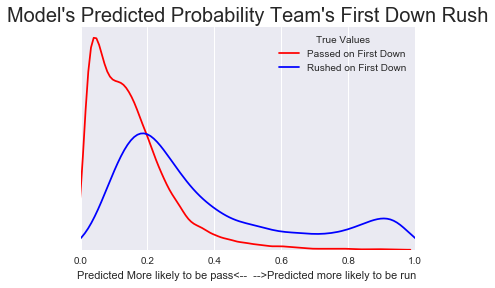

In [66]:
# Visualize how well our propensity-scoring model separates the classes
# A good model will result in most of the red distribution (plays following passes) on the left,
# and the blue distribution (following rushes) further to the right

ax = plt.gca()
sns.kdeplot(df[df[treatment]==0].propensity, color='red', label='Passed on First Down', ax=ax, clip=[0,1])
sns.kdeplot(df[df[treatment]==1].propensity, color='blue', label='Rushed on First Down', ax=ax, clip=[0,1])

plt.xlim([0,1])
plt.title('Model\'s Predicted Probability Team\'s First Down Rush', fontsize=20)
plt.legend(title="True Values")
plt.yticks([])
plt.xlabel('Predicted More likely to be pass<--  -->Predicted more likely to be run ')

# Evaluate the new balance - First visually, then numerically with standardized mean differences

In [67]:
def weighted_histograms(df, feature, treatment, bins=50):
    # Takes a dataframe and creates two series, one for each treatment group
    # using the propensity-score-weights to simulate the new histogram
    # If a datapoint had a weight of 4, the series will have 4 items in the list with that datapoint's value

    # Mostly for visualization purposes - for most analyses I can multiply a feature by the weight,
    # but it looks like way too much work to make kde plotting functions accept a weight parameter

    group = {}
    group[0] = np.histogram(df[df[treatment]==0][feature], bins=bins, weights=df[df[treatment]==0]['weight'])
    group[1] = np.histogram(df[df[treatment]==1][feature], bins=bins, weights=df[df[treatment]==1]['weight'])
    # np.histogram returns two lists: 0 is the sum of the weights (how many times the values occurred, reweighted)
    # 1 is the bin bottom - the value that occurred a certain number of times
    
    new_hists = [[],[]]
    
    for treatment_condition in [0,1]:
        for i in range(len(group[treatment_condition][0])):
            value = group[treatment_condition][1][i]
            count = group[treatment_condition][0][i]
            
            # I had previously used 'round' but there are frequently repeated weights of around .6, which always rounded up.   

            floored_count = int(count)
            remainder = count - floored_count
            if remainder >=1:
                count = count + 1
                remainder = remainder - 1
            new_hists[treatment_condition] = new_hists[treatment_condition] + [value] * count

    new_hists[0] = pd.Series(new_hists[0])
    new_hists[1] = pd.Series(new_hists[1])
    return new_hists    

In [68]:
def show_kde_plots(df, feature, treatment, bins=50,  labels=None, title=None, **shared_kwargs):
    # For quick visualizations to show how the distribution of a feature was split between treatment groups
    # before and after reweighting
    
    new_hists = weighted_histograms(df, feature=feature, treatment=treatment, bins=bins)
    
    if labels!=None:
        labels = labels
    else:
        labels = [treatment+" = False", treatment+" = True"]
    
    if title!=None:
        title=title
    else:
        title='Distribution of '+feature.upper()+'\nSplit by '+treatment
        
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)

    plt.title('Original '+title, fontsize=20)
    sns.kdeplot(df[df[treatment]==0][feature], shade=True, label=labels[0], color='red', ax=plt.gca(), **shared_kwargs)
    sns.kdeplot(df[df[treatment]==1][feature], shade=True, label=labels[1], color='blue', ax=plt.gca(), **shared_kwargs)
#     plt.xlim([-50,50])
    plt.ylabel('Distribution Density')
    plt.xlabel(feature)

    plt.subplot(1,2,2)
    plt.title('Reweighted '+title, fontsize=20)
    sns.kdeplot(pd.Series(new_hists[0]), shade=True, label=labels[0], color='red', ax=plt.gca(), **shared_kwargs)
    sns.kdeplot(pd.Series(new_hists[1]), shade=True, label=labels[1], color='blue', ax=plt.gca(), **shared_kwargs)
#     plt.xlim([-50,50])
    plt.ylabel('Distribution Density')
    plt.xlabel(feature)


/Users/jessegalef/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[None]

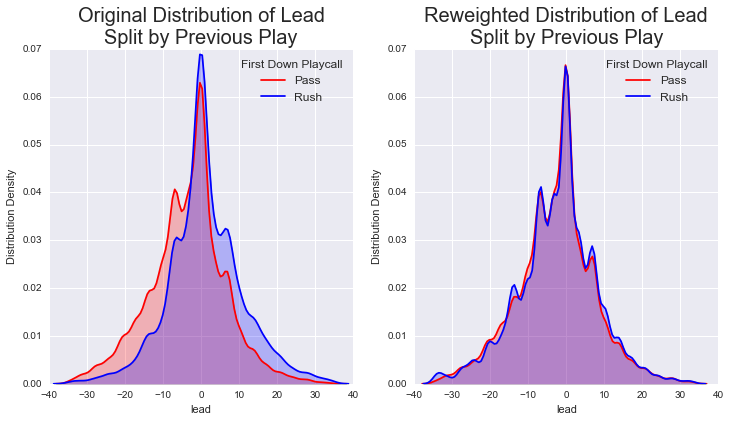

In [166]:
show_kde_plots(df, feature='lead', treatment='prevrushAttempt', bins=range(-35,35),
               labels=['Pass','Rush'], title='Distribution of Lead\nSplit by Previous Play', clip=[-35,35])
legend1 = plt.subplot(1,2,1).legend(title='First Down Playcall', fontsize=12)
legend2 = plt.subplot(1,2,2).legend(title='First Down Playcall', fontsize=12)
plt.setp(legend1.get_title(),fontsize=12)
plt.setp(legend2.get_title(),fontsize=12)

/Users/jessegalef/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


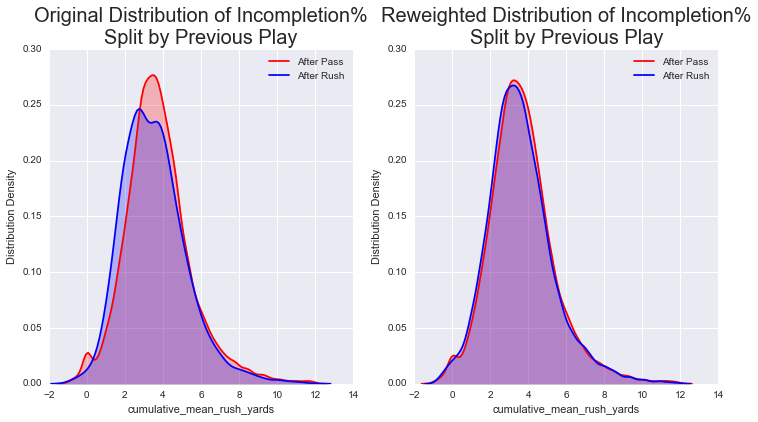

In [70]:
plt.figure(figsize=[10,5])
show_kde_plots(df, feature='cumulative_mean_rush_yards', treatment='prevrushAttempt', bins=np.arange(-1,15, .1),
               labels=['After Pass','After Rush'], title='Distribution of Incompletion%\nSplit by Previous Play', clip=[-1,12], )

## Compare the standardized mean differences for each feature before and after the re-weighting process

In [71]:


def standard_differences(df, which_cols=features, split_by='prevrushAttempt', weights=[]):
    if len(weights) != 0:
        weighted_means = {}
        weighted_variance={}
        for i in [0,1]:
            this_group = df[df[split_by]==i][which_cols]
            these_weights = weights[df[split_by]==i]
            
            weighted_means[i] = (this_group.T * these_weights).T.sum() / these_weights.sum()

            part1 = (these_weights.sum() / (these_weights.sum()**2 - sum(these_weights**2)))
            part2 = ((((this_group - weighted_means[i])**2).T * these_weights).T).sum()
            weighted_variance[i]= part1 * part2
        return (weighted_means[1] - weighted_means[0]) / ((weighted_variance[1]+weighted_variance[0])/2.)**.5

    else:
        diff_in_means = (df[df[split_by]==1][which_cols].mean() - df[df[split_by]==0][which_cols].mean())
        pooled_variance = ((df[df[split_by]==1][which_cols].std()**2 + df[df[split_by]==0][which_cols].std()**2)/2.)**.5
        return diff_in_means / pooled_variance
        


In [170]:
smd_features = [feature for feature in features if feature not in ['togo']]

smd = pd.DataFrame(abs(standard_differences(df, which_cols=smd_features, split_by='prevrushAttempt')), columns=['unweighted'])
smd['reweighted'] = abs(standard_differences(df, which_cols=smd_features, split_by='prevrushAttempt', weights=df.weight))

smd.sort_values('unweighted', ascending=True, inplace=True)
smd.index = ['Lead',
             'Behind, Short on Time',
             'Incompletion% in Game',
             'Yards/Pass',
             'Yards/Rush',
             'Season Incompletion %',
             'Last Season Rush %',
             'Rush Yards in Game',
             'Season Yards/Pass',
             'Season Rush Yards',
             'Pass Yards in Game',
             'Time Left in Half',
             'Last Season Incompletion %',
             'Last Season Yards/Rush',
             'Season Yards/Rush',
             'Season Pass Yards',
             'Yardline'][::-1] # Accidentally typed these in reverse order, this puts them right



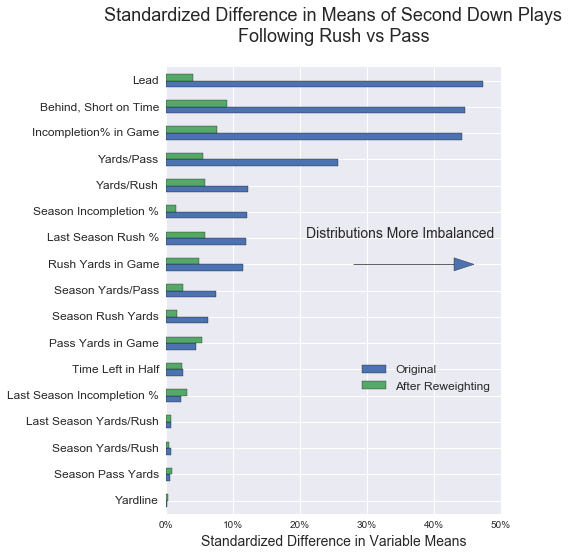

In [179]:

smd.plot(kind='barh', figsize=[6,8])
plt.xlabel('Standardized Difference in Variable Means', fontsize=14)
plt.xticks([0,.1,.2,.3,.4,.5], ['0%', '10%','20%','30%','40%','50%'])
plt.title('Standardized Difference in Means of Second Down Plays\nFollowing Rush vs Pass\n', fontsize=18)
plt.yticks(fontsize=12)
plt.legend(['Original','After Reweighting'], loc='lower right', bbox_to_anchor=[1,.25], fontsize=12)

plt.text(.35,10,'Distributions More Imbalanced', horizontalalignment='center', fontsize=14)
plt.arrow(.28,9,.15,0, head_width=.5, head_length=.03)
# plt.tight_layout(rect=[0,0,1,.8])

In [78]:
smd.describe()

,unweighted,reweighted
count,17.000000,17.000000
mean,0.137914,0.036217
std,0.163868,0.026507
min,0.000756,0.003028
25%,0.022606,0.014696
50%,0.074719,0.031400
75%,0.121617,0.055254
max,0.473324,0.090283


In [79]:
smd

,unweighted,reweighted
ydline,0.000756,0.003028
cumulative_season_pass_yards,0.006277,0.008839
cumulative_season_rush_average,0.006914,0.004241
prev_season_rush_ydsnet_average,0.007660,0.007377
prev_season_incompletion_percent,0.022606,0.031400
timehalf,0.025272,0.023143
cumulative_pass_yards,0.044242,0.053713
cumulative_season_rush_yards,0.062468,0.016052
cumulative_season_pass_average,0.074719,0.024853
cumulative_rush_yards,0.114824,0.049697


# Answer to Question 1: After re-weighting, is there still a significant difference in playcalling on 2nd and 10 after a rush vs. after a pass?

In [80]:
print "Original Split without Inverse Propensity Weighting"
cross = pd.crosstab(df[target], df[treatment])
print 'pvalue of:', chi2_contingency(cross)[1]
cross/cross.sum()


Original Split without Inverse Propensity Weighting
pvalue of: 1.73888518602e-50


prevrushAttempt,0.0,1.0
rushAttempt,,
0,0.563705,0.680734
1,0.436295,0.319266


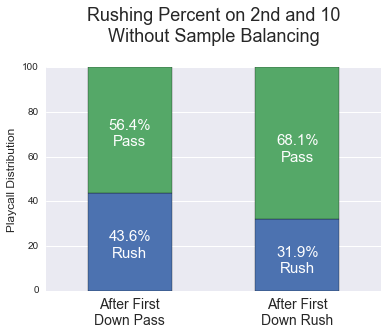

In [85]:

percents = cross/cross.sum() * 100
percents.T[[1,0]].plot(kind='bar', stacked=True, legend=False)

plt.title('Rushing Percent on 2nd and 10\nWithout Sample Balancing\n', fontsize=18)

plt.ylabel('Playcall Distribution', fontsize=12)
plt.xticks([0,1],['After First\nDown Pass', 'After First\nDown Rush'], fontsize=14, rotation=0)
plt.xlabel('')

plt.text(0, 15, '{:.1f}%\nRush'.format(percents.ix[1,0]), color='white', fontsize=15, horizontalalignment='center')
plt.text(1, 8, '{:.1f}%\nRush'.format(percents.ix[1,1]), color='white', fontsize=15, horizontalalignment='center')

plt.text(0, 65, '{:.1f}%\nPass'.format(percents.ix[0,0]), color='white', fontsize=15, horizontalalignment='center')
plt.text(1, 58, '{:.1f}%\nPass'.format(percents.ix[0,1]), color='white', fontsize=15, horizontalalignment='center')
# plt.tight_layout(rect=[0,0,1,.85])

In [82]:
print "Split After Inverse Propensity Weighting"
reweighted_cross = pd.crosstab(df[target], df[treatment], df['weight'], aggfunc=sum)
print 'pvalue of:', chi2_contingency(reweighted_cross)[1]
reweighted_cross/reweighted_cross.sum()


Split After Inverse Propensity Weighting
pvalue of: 1.48564655743e-229


prevrushAttempt,0.0,1.0
rushAttempt,,
0,0.545243,0.739873
1,0.454757,0.260127


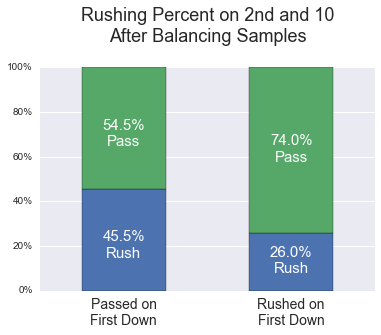

In [187]:

reweighted_percents = reweighted_cross/reweighted_cross.sum() * 100
reweighted_percents.T[[1,0]].plot(kind='bar', stacked=True, legend=False)

plt.title('Rushing Percent on 2nd and 10\nAfter Balancing Samples\n', fontsize=18)

# plt.ylabel('Playcall Distribution', fontsize=12)
plt.yticks(range(0,101,20), [str(p)+'%' for p in range(0,101,20)])
plt.xticks([0,1],['Passed on\nFirst Down', 'Rushed on\nFirst Down'], fontsize=14, rotation=0)
plt.xlabel('')

plt.text(0, 15, '{:.1f}%\nRush'.format(reweighted_percents.ix[1,0]), color='white', fontsize=15, horizontalalignment='center')
plt.text(1, 8, '{:.1f}%\nRush'.format(reweighted_percents.ix[1,1]), color='white', fontsize=15, horizontalalignment='center')

plt.text(0, 65, '{:.1f}%\nPass'.format(reweighted_percents.ix[0,0]), color='white', fontsize=15, horizontalalignment='center')
plt.text(1, 58, '{:.1f}%\nPass'.format(reweighted_percents.ix[0,1]), color='white', fontsize=15, horizontalalignment='center')
# plt.tight_layout(rect=[0,0,1,.85])

# Apply Analysis to 2nd and Each Distance

In [87]:
second = present[(present.down==2)&(present.togo <=15)&(present.prevtogo==10)].copy()
for i in range(1,16):
    print i
    propensities, weights = get_df_weights(second[second.togo==i], 
                                           classifier=GradientBoostingClassifier(), 
                                           X_columns=features, 
                                           treatment='prevrushAttempt',
                                           verbose=1, 
                                           n_folds=10,
                                          params=params)
    second.ix[second.togo==i,'weight'] = weights


1
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.0min finished


roc_auc score of 0.76376333225
2
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.8min finished


roc_auc score of 0.767456095914
3
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.1min finished


roc_auc score of 0.765793599673
4
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.8min finished


roc_auc score of 0.761418226073
5
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.3min finished


roc_auc score of 0.773486612914
6
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.5min finished


roc_auc score of 0.762926258742
7
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.5min finished


roc_auc score of 0.772884648501
8
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.3min finished


roc_auc score of 0.768935473002
9
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.4min finished


roc_auc score of 0.738063635571
10
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.0min finished


roc_auc score of 0.78993350651
11
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   53.2s finished


roc_auc score of 0.759312193619
12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   33.5s finished


roc_auc score of 0.745243829019
13
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   23.7s finished


roc_auc score of 0.715293806267
14
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   16.2s finished


roc_auc score of 0.792737259689
15
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   13.6s finished


roc_auc score of 0.742483802868


In [88]:
second.to_csv('second_down_with_weights.csv')

# Skip to here to read in second down weighted df

In [45]:
second = pd.read_csv('second_down_with_weights.csv')

In [89]:
from statsmodels.stats.proportion import proportion_confint

dist = second.groupby(['togo','prevrushAttempt','rushAttempt']).sum()[['weight']]


In [90]:
with_ci = []
for distance in range(1,16):
    this_row = {}
    for prevRush in [0,1]:
        this_combo = dist.loc[distance].loc[prevRush]
        ci_bounds = proportion_confint(this_combo.loc[1], this_combo.sum())
        this_row[prevRush*3] = (this_combo.loc[1] / this_combo.sum())[0]
        this_row[prevRush*3+1], this_row[prevRush*3+2] = ci_bounds[0][0], ci_bounds[1][0]
    with_ci.append(this_row)

with_ci = pd.DataFrame(with_ci, index=range(1,16))
with_ci.columns=['After_pass_mean','After_pass_ci_low','After_pass_ci_high',
                                                           'After_rush_mean','After_rush_ci_low','After_rush_ci_high']

(1, 15)

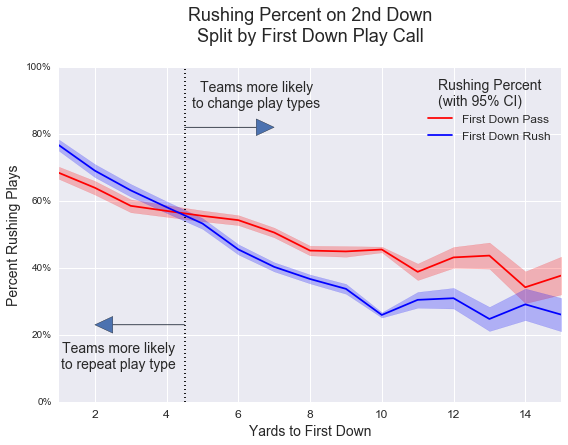

In [201]:
plt.figure(figsize=[9,6])
ci_alpha = .25
plt.fill_between(with_ci.index, with_ci['After_pass_ci_low'], with_ci['After_pass_ci_high'], alpha=ci_alpha, color='red')
plt.fill_between(with_ci.index, with_ci['After_rush_ci_low'], with_ci['After_rush_ci_high'], alpha=ci_alpha, color='blue')
with_ci['After_pass_mean'].plot(color='red')
with_ci['After_rush_mean'].plot(color='blue')


plt.title('Rushing Percent on 2nd Down\nSplit by First Down Play Call\n', fontsize=18)
plt.xlabel('Yards to First Down', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Percent Rushing Plays', fontsize=14)
plt.yticks(np.arange(0,1.1,.2), [str(p)+'%' for p in range(0,101,20)])
plt.ylim([0,1])
legend = plt.legend(['First Down Pass', 'First Down Rush'], fontsize=12, 
           loc='upper right',
#            bbox_to_anchor=[1.02,1],
          title='Rushing Percent\n(with 95% CI)')

plt.setp(legend.get_title(),fontsize=14)

# plt.text(12,.52, 'Rushing Percent\nAfter a Pass', horizontalalignment='center', fontsize=14)
# plt.text(12,.11,  'Rushing Percent\nAfter a Rush', horizontalalignment='center', fontsize=14)

plt.vlines(4.5,0,1,linestyle='dotted')

plt.text(2.67, .1, 'Teams more likely\nto repeat play type', horizontalalignment='center', fontsize=14)
plt.arrow(4.5, .23, -2,0, head_width=0.05, head_length=.5)

plt.text(6.5, .88, 'Teams more likely\nto change play types', horizontalalignment='center', fontsize=14)
plt.arrow(4.5, .82, 2,0, head_width=0.05, head_length=.5)

plt.xlim([1,15])

# Propensity Weighting for Incompletions

## Comparing 2nd and 10 via incompletion vs 2nd and 10 vs completed pass for no gain

In [93]:
pass_to_ten = second[(second.prevpassAttempt==1)&(second.togo==10)].copy()

passing_importances = get_feature_importances(pass_to_ten[potential_features], pass_to_ten.rushAttempt)


In [94]:
passing_importances.sort_values()

togo                                      0.000000
runOutClock                               0.000383
pass_comparative_adv                      0.024118
def_prev_season_pass_ydsnet_average       0.024991
def_prev_season_rush_ydsnet_average       0.025523
prev_season_offense_rush_yard_adv         0.025577
def_prev_season_incompletion_percent      0.026035
prev_season_pass_ydsnet_average           0.026402
prev_season_offense_pass_yard_adv         0.026804
def_prev_season_rush_percent              0.028014
prev_season_incompletion_percent          0.032795
prev_season_rush_percent                  0.033553
prev_season_rush_ydsnet_average           0.033684
timehalf                                  0.038128
cumulative_season_pass_yards              0.041505
cumulative_rush_yards                     0.041775
cumulative_season_rush_yards              0.043602
ydline                                    0.046145
hurrying                                  0.048149
cumulative_mean_rush_yards     

In [95]:
pass_to_ten_features = passing_importances[passing_importances >= .04].index.values


In [96]:

propensities, weights = get_df_weights(pass_to_ten, 
                                       classifier=GradientBoostingClassifier(), 
                                       X_columns=pass_to_ten_features, 
                                       treatment='prevIncomplete',
                                       verbose=1, 
                                       n_folds=10)

pass_to_ten['weight'] = weights

roc_auc score of 0.719070516185


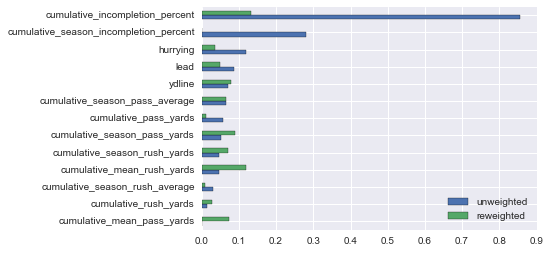

In [97]:
incomplete_smd = pd.DataFrame(abs(standard_differences(pass_to_ten, which_cols=pass_to_ten_features, split_by='prevIncomplete')), columns=['unweighted'])
incomplete_smd['reweighted'] = abs(standard_differences(pass_to_ten, which_cols=pass_to_ten_features, split_by='prevIncomplete', weights=pass_to_ten.weight))

incomplete_smd.sort_values('unweighted').plot(kind='barh')
# .plot(kind='barh', ax=ax, alpha=.5, color='blue', stacked=True)



In [98]:
inc_split = pd.crosstab(pass_to_ten.rushAttempt, pass_to_ten.prevIncomplete, values=pass_to_ten.weight, aggfunc=sum)
print 'Chi-squared contingency p-value of', chi2_contingency(inc_split)[1]
inc_split / inc_split.sum()

Chi-squared contingency p-value of 2.29802950762e-05


prevIncomplete,0.0,1.0
rushAttempt,,
0,0.585129,0.555846
1,0.414871,0.444154


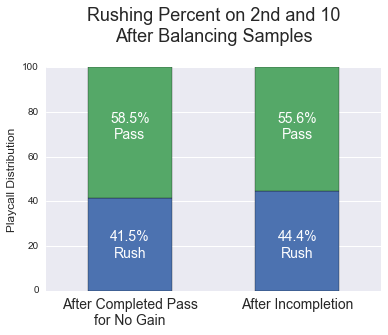

In [104]:

reweighted_percents = inc_split/inc_split.sum() * 100
reweighted_percents[[0,1]].loc[[1,0]].T.plot(kind='bar', stacked=True, legend=False)

plt.title('Rushing Percent on 2nd and 10\nAfter Balancing Samples\n', fontsize=18)

plt.ylabel('Playcall Distribution', fontsize=12)
plt.xticks([0,1],['After Completed Pass\nfor No Gain', 'After Incompletion'], fontsize=14, rotation=0)
plt.xlabel('')

plt.text(0, 15, '{:.1f}%\nRush'.format(reweighted_percents.ix[1,0]), color='white', fontsize=14, horizontalalignment='center')
plt.text(1, 15, '{:.1f}%\nRush'.format(reweighted_percents.ix[1,1]), color='white', fontsize=14, horizontalalignment='center')

plt.text(0, 68, '{:.1f}%\nPass'.format(reweighted_percents.ix[0,0]), color='white', fontsize=14, horizontalalignment='center')
plt.text(1, 68, '{:.1f}%\nPass'.format(reweighted_percents.ix[0,1]), color='white', fontsize=14, horizontalalignment='center')
# plt.tight_layout(rect=[0,0,1,.85])

In [105]:
print "Not Weighted"
unweighted_inc_split_cross = pd.crosstab(pass_to_ten.rushAttempt, pass_to_ten.prevIncomplete)
print 'Chi-squared contingency p-value of', chi2_contingency(unweighted_inc_split_cross)[1]
unweighted_inc_split_cross / unweighted_inc_split_cross.sum()

Not Weighted
Chi-squared contingency p-value of 0.8828400524


prevIncomplete,0.0,1.0
rushAttempt,,
0,0.567434,0.563578
1,0.432566,0.436422
